# OpenStreetData Case Study for the Metro Area of Berlin, Germany

## Map Area

Berlin Metro Area, Germany. Berlin was choosen, since it is my hometown.

## Data Wrangling

I've downloaded the available data from https://mapzen.com/data/metro-extracts/ (May 2nd, 2016), extracted nodes and ways and imported the data into a sqlite database (See file data_preparation.py, database schama see schema.txt). Some unknown characters in usernames (kyrillic) lead to problem extracting the 'nodes' and 'ways' from the OSM File. SQL import errors lead to a not complete database. 

Therefore, the count of rows was checked against the csv files:

In [11]:
import sqlite3
from collections import Counter, defaultdict
import datetime
import matplotlib.pyplot as plt
import pandas as pd


conn = sqlite3.connect('data1.db')
c = conn.cursor()

def time_from_timestamp(timestamp_input):
    # Helper to get a datetime object from the sql timestamp fields.
    # Precision is limited to day.
    year = int(timestamp_input[:4])
    month = int(timestamp_input[5:7])
    day = int(timestamp_input[8:10])
    return datetime.datetime(year, month, day)

def formatnum(num):
    # Helper for printing number with the comma.
    return "{:,}".format(num)

In [2]:
# Warning: Takes some time with the big csv files.

df_nodes = pd.DataFrame.from_csv('nodes.csv')
df_nodes_tags = pd.DataFrame.from_csv('nodes_tags.csv')
df_ways = pd.DataFrame.from_csv('ways.csv')
df_ways_tags = pd.DataFrame.from_csv('ways_tags.csv')
df_ways_nodes = pd.DataFrame.from_csv('ways_nodes.csv')

In [6]:
print("Count of rows in csv files")
print("nodes:      ", formatnum(len(df_nodes.index.values)))
print("nodes_tags:  ", formatnum(len(df_nodes_tags.index.values)))
print("ways:        ", formatnum(len(df_ways.index.values)))
print("ways_tags:   ", formatnum(len(df_ways_tags.index.values)))
print("ways_nodes: ", formatnum(len(df_ways_nodes.index.values)))

Count of rows in csv files
nodes:       10,460,000
nodes_tags:   3,658,234
ways:         1,596,861
ways_tags:    4,191,676
ways_nodes:  13,362,536


Count of rows in database:

    SELECT Count(*) FROM nodes;
    > 10,460,000
    
    SELECT Count(*) FROM nodes_tags;
    > 3,658,235
    
    SELECT Count(*) FROM ways;
    > 1,596,861
    
    SELECT Count(*) FROM ways_tags;
    > 4,191,677
    
    SELECT Count(*) FROM ways_nodes;
    > 13,362,537

The tables nodes_tags, ways_tags and ways_nodes are one row longer. A manual inspection revealed that the column names were added as a data row. These rows were removed manualy. 

Furthermore, since nodes_tags and nodes_ways are sub to nodes and ways, ids from the tags file should allways refer to a valid id in the nodes or ways file.

In [4]:
print(set(df_nodes_tags.index.values) <= set(df_nodes.index.values))
print(set(df_ways_tags.index.values) <= set(df_ways.index.values))

True
True


In [5]:
nodes_set = set([n[0] for n in c.execute("SELECT id FROM nodes").fetchall()])
nodes_tags_set = set([n[0] for n in c.execute("SELECT id FROM nodes_tags").fetchall()])
ways_set = set([n[0] for n in c.execute("SELECT id FROM ways").fetchall()])
ways_tags_set = set([n[0] for n in c.execute("SELECT id FROM ways_tags").fetchall()])

print(nodes_tags_set <= nodes_set)
print(ways_tags_set <= ways_set)

True
True


## File Sizes

* 'berlin.osm':    2.29 GB (uncompressed)
* 'nodes.csv':      833 MB
* 'nodes_tags.csv': 131 MB
* 'ways.csv':        93 MB
* 'ways_nodes.csv': 316 MB
* 'ways_tags.csv':  140 MB

## Evaluating the Data

While evaluating the data the following problems were encountered:

* (nodes table) Columns lat and lon use different precision. 
* (nodes_tags table) Column key has values that are probably inconsistencies, like 'addr' and 'address' or 'abbr' and 'abrevation'
* (nodes_tags table) The key 'fixme', 'FIXME' and 'TODO' was found.
* (ways_tags table) The column value holds unexpected values for column key filtered for maxspeed. 250 is unlikely (39 times) as well as 210 or 190. Also the max limit 30 seems to be encoded in various different ways (30, DE:zone30, DE:zone:30, DE:30, PL:zone30, DE:zone(:30), zone30)
* (ways_tags table) The column value holds unexpected values for the column key filtered by postcode. Postcodes are five digits starting (in Berlin) with a 1. '66-470' (1,632 times), '74-500' (1,486 times) and '74-505' (938 times) do not match this criteria. There are codes starting with a '0' (mostly area around Berlin) and one code is '39264' (a place called Deetz and quite a bit away from Berlin).

## Evaluating the problems

### nodes table : columns lat and lon

An evaluation found, that there are 20 rows in the nodes table, that have a precision of 3 places or less after the dot. This means the precisions is somewhere in the range of about +/- 100 Meters .Therefore, for most uses this would be considered not accurate enough. Most accuracy ist registered 4 places better (7 digits after the dot). Examining the relating nodes_tags and ways_tags for these rows revelead that most rows represented an real world object that had a big 'footprint' and therefore can not be pinpointed to a very precise location. Five rows are villages and eleven are lakes. For the rest we might not rule out the possibilty that just zeros were removed at the end and that the lon and lat actually are the most precise coordinates

In [7]:
statement = """
SELECT lat, lon, id
FROM nodes
"""

data = [n for n in c.execute(statement).fetchall() if len(str(n[0])) <= 6 and len(str(n[1])) <= 6]

len(data)

# for n in data:
#     print(n)

20

In [9]:
for lon, lat, id_ in data:
    statement = "SELECT * FROM nodes_tags WHERE id = {}".format(id_)
    d = c.execute(statement).fetchall()
    if d:
        for n in d:
            if n[1] == 'place':          
                print(n)

(240030792, 'place', 'village', 'regular\r')
(240041259, 'place', 'village', 'regular\r')
(240045498, 'place', 'village', 'regular\r')
(240070698, 'place', 'village', 'regular\r')
(240093837, 'place', 'village', 'regular\r')


In [10]:
# Running takes quite a while

for lon, lat, id_ in data:
    statement = """SELECT ways_tags.key, ways_tags.value, ways_tags.type, nodes.id
    FROM ways_tags
    JOIN ways ON ways.id = ways_tags.id
    JOIN ways_nodes ON ways_nodes.id = ways.id
    JOIN nodes ON ways_nodes.node_id = nodes.id
      WHERE nodes.id = {};""".format(id_)
    
    for n in c.execute(statement).fetchall():
        if n[0] == 'water':
            print(n)

('water', 'lake', 'regular\r', 75809260)
('water', 'lake', 'regular\r', 75811800)
('water', 'lake', 'regular\r', 75811870)
('water', 'lake', 'regular\r', 75811875)
('water', 'lake', 'regular\r', 75811998)
('water', 'lake', 'regular\r', 75812002)
('water', 'lake', 'regular\r', 75812076)


### nodes_tags table:  Inconsistent keys

In [12]:
statement = """
SELECT key, Count(key)
FROM nodes_tags
GROUP BY key
ORDER BY Count(key) DESC
LIMIT 25;
"""
print("25 most common keys in nodes_tags table")
c.execute(statement).fetchall()

25 most common keys in nodes_tags table


[('housenumber', 387564),
 ('street', 386634),
 ('city', 383870),
 ('postcode', 381582),
 ('country', 364269),
 ('suburb', 322496),
 ('source', 263220),
 ('natural', 128327),
 ('leaf_type', 114582),
 ('leaf_cycle', 109711),
 ('name', 85603),
 ('amenity', 54410),
 ('highway', 37567),
 ('wheelchair', 31144),
 ('entrance', 27180),
 ('power', 24791),
 ('type', 21607),
 ('barrier', 19195),
 ('operator', 18235),
 ('shop', 17823),
 ('railway', 17451),
 ('created_by', 17023),
 ('ref', 16778),
 ('website', 15989),
 ('public_transport', 15660)]

In [13]:
statement = """
SELECT key
FROM nodes_tags
"""

nodes_tags_list = list(set([n[0] for n in c.execute(statement).fetchall()]))

possible_doubles = []
for tag in nodes_tags_list:
    for other_tag in nodes_tags_list:
        if tag == other_tag:
            pass
        elif ":" in other_tag:
            pass
        elif len(tag) == 2:
            pass
        elif other_tag.startswith(tag):
            possible_doubles.append([tag, other_tag])

# Uncomment to see possible doubles
# possible_doubles

I'm looking at some of the possible key that have the same meaning:
* 'art', 'artist'
* 'drink_water', 'drinking_water'
* 'addr', 'address'

In [14]:
statement = """
SELECT * 
FROM nodes_tags
WHERE key = "art" OR key = "artist"
LIMIT 20;
"""

for n in c.execute(statement).fetchall():
    print(n)

(277525548, 'artist', 'Hermann Hosaeus', 'regular\r')
(313826576, 'artist', 'Brigitte und Martin Matschinsky-Denninghoff', 'regular\r')
(437150946, 'artist', 'Henry Moore', 'regular\r')
(440937810, 'artist', 'Gerhard Thieme', 'regular\r')
(1038089721, 'artist', 'Heinz Mack', 'regular\r')
(1049418449, 'artist', 'Rainer Fest', 'regular\r')
(1181494510, 'artist', 'Gottfried Gruner', 'regular\r')
(1375278177, 'art', 'yes', 'museum\r')
(1482191891, 'artist', 'Mark di Suvero', 'regular\r')
(1482191892, 'artist', 'Frank Stella', 'regular\r')
(1482191893, 'artist', 'Keith Haring', 'regular\r')
(1489096811, 'artist', 'Bernhard Heiliger', 'regular\r')
(1670240199, 'art', 'exhibition_space', 'regular\r')
(1977116866, 'art', 'gallery', 'regular\r')
(1979988661, 'artist', 'Ernst Leonhardt', 'regular\r')
(2123579006, 'artist', 'Egbert Broerken', 'regular\r')
(2123643791, 'artist', 'Egbert Broerken', 'regular\r')
(2123680364, 'artist', 'Egbert Broerken', 'regular\r')
(2554278342, 'artist', 'Gerhard S

'art' seems not to be an abrevation for 'artist'. 

In [15]:
statement = """
SELECT * 
FROM nodes_tags
WHERE key = "drink_water"
LIMIT 10;
"""

for n in c.execute(statement).fetchall():
    print(n)

(2459611822, 'drink_water', 'yes', 'regular\r')


In [16]:
statement = """
SELECT * 
FROM nodes_tags
WHERE key = "drinking_water"
GROUP BY value
LIMIT 25;
"""

for n in c.execute(statement).fetchall():
    print(n)

(3627125409, 'drinking_water', 'Bah', 'regular\r')
(4450877764, 'drinking_water', 'no', 'regular\r')
(3872785663, 'drinking_water', 'pump', 'regular\r')
(4367704200, 'drinking_water', 'seasonal', 'regular\r')
(4396179327, 'drinking_water', 'yes', 'regular\r')


In [17]:
statement = """
SELECT * 
FROM nodes_tags
WHERE key = "drinking_water"
AND value = "Bah"
LIMIT 25;
"""

for n in c.execute(statement).fetchall():
    print(n)

(3627125409, 'drinking_water', 'Bah', 'regular\r')


The single entry "drink_water" seems to be not different from "drinking_water". Therefore "drink_water" could be changed into "drinking_water".

The value also seems to be not standardized. It is sometime an boolean value (yes or no) and sometimes a further description. Also the value "Bah" seems pointless.

In [18]:
statement = """
SELECT key, Count(*)
FROM nodes_tags
WHERE key = "addr" OR key = "address"
GROUP BY key
"""

for n in c.execute(statement).fetchall():
    print(n)

('addr', 5486)
('address', 3)


In [19]:
statement = """
SELECT *
FROM nodes_tags
WHERE key = "address"
"""

for n in c.execute(statement).fetchall():
    print(n)

(1879818772, 'address', 'Am Parsteinsee 1, 16278 Angermünde', 'regular\r')
(1880630233, 'address', 'Haus Lindenstraße, Lindenstraße 43, 16278 Angermünde', 'regular\r')
(1901746292, 'address', 'Carrée Seestrasse, Geb.B, Aufg. 12/13; 3.OG', 'description\r')


In [20]:
statement = """
SELECT *
FROM nodes_tags
WHERE key = "addr"
LIMIT 10;
"""

for n in c.execute(statement).fetchall():
    print(n)

(59954787, 'addr', 'Müllerhaus, Alt-Marzahn 63, 12685 Berlin - Jürgen Wolf', 'contact\r')
(84644791, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')
(105184468, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')
(304565290, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')
(310462222, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')
(518840681, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')
(522469205, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')
(522472057, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')
(523257110, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')
(541075880, 'addr', 'Geoportal Berlin / Hauskoordinaten', 'source\r')


'addr' seems to be the dominantly used key. An inspection of the 3 rows did not reveal anything special. Therefore the 3 rows should be changed to 'addr'.

### nodes_tags table: fixme and todo keys

In [21]:
statement = """
SELECT key, Count(*)
FROM nodes_tags
WHERE key = "fixme" OR key = "FIXME" OR key = "todo" OR key = "TODO"
GROUP BY key
LIMIT 10;
"""
for n in c.execute(statement).fetchall():
    print(n)

('FIXME', 194)
('TODO', 1)
('fixme', 968)


In [22]:
statement = """
SELECT *
FROM nodes_tags
WHERE key = "fixme" OR key = "FIXME" OR key = "todo" OR key = "TODO"
LIMIT 3;
"""
for n in c.execute(statement).fetchall():
    print(n)

(484061, 'FIXME', 'according to my observation on 2016-07-29, there is no device anymore. Confirm? -- it is temporary', 'regular\r')
(27411605, 'fixme', 'Zs-Anzeiger?', 'regular\r')
(29123772, 'fixme', 'tracks not accurate', 'regular\r')


In [24]:
statement = """
SELECT *
FROM nodes_tags, nodes
WHERE nodes_tags.id = nodes.id AND nodes_tags.id = 484061
LIMIT 3;
"""
for n in c.execute(statement).fetchall():
    print(n)

(484061, 'FIXME', 'according to my observation on 2016-07-29, there is no device anymore. Confirm? -- it is temporary', 'regular\r', 484061, 52.290366, 12.9181252, 'gadacz', 121453, 13, 42375942, '2016-09-23T14:45:47Z\r')
(484061, 'highway', 'speed_camera', 'regular\r', 484061, 52.290366, 12.9181252, 'gadacz', 121453, 13, 42375942, '2016-09-23T14:45:47Z\r')
(484061, 'maxspeed', '100', 'regular\r', 484061, 52.290366, 12.9181252, 'gadacz', 121453, 13, 42375942, '2016-09-23T14:45:47Z\r')


An inspection revelead no simple solution to fix the 'fixme' programaticaly. I looked at the first row, and I don't know it the speed camera at the A9/A10 highway is temporary or not.

'FIXME', 'TODO', 'fixme' could be joined to just 'fixme'.

### ways_tags table: maxspeed

The evaluation of the ways_tags table showed that the meaning of the key "maxspeed" is ambigious. I sometimes refers to the speedlimit imposed by law (eg. 30, 50, 100) and sometimes to the technical maxspeed as comissioned (230). Both have a different meaning and should not be mixed into one key. The type of the value also differed often between plain numbers (30, 50, ...), number with a unit or sometimes a long text with a description.

The evaluation also showed that the key to designate a speed limit of 30 kph was predominatly refered to by the value '30'. There were six more differenz kind of values that obviously meant the same (DE:zone30, etc.). Althought there is a difference if it is a speedlimit of 30 or speed limit zone 30, but the maxspeed is same for both cases. So I would think it would be smarter to limit the speedlimit key to just the numeric limit and add the zone information in another row with a new tag.

In [25]:
# Find everything related to maxspeed 30:
statement = """
SELECT key, value, COUNT(key)
FROM ways_tags
WHERE key = "maxspeed"
AND value LIKE "%30%"
GROUP BY value
ORDER BY COUNT(key) DESC;
"""

print("key: maxspeed")
for n in c.execute(statement).fetchall():
    f = n[1][:15]
    print(f, " " * (20 - len(f) + (6 - len(str(n[2])))), n[2])

key: maxspeed
30                     31626
DE:zone30                830
DE:zone:30               824
DE:30                    201
130                      156
230                       91
Laut Anlage 13.           28
PL:zone30                 23
DE:zone(:30)               2
Zs3 "4" am Sign            1
zone30                     1


### ways_tags table: postcode

In [27]:
# Show all postcodes that are longer or shorter than 5 digits.

statement = """
SELECT value, COUNT(key)
FROM ways_tags
WHERE key = "postcode"
GROUP BY value
ORDER BY COUNT(key) DESC;
"""

for n in c.execute(statement).fetchall():
    if len(n[0]) != 5:
        print(n)

('66-470', 1632)
('74-500', 1486)
('74-505', 938)
('74-520', 860)
('74-510', 785)
('74-503', 671)
('74-405', 101)
('74-406', 78)
('69-113', 76)
('74-400', 69)
('66-629', 61)
('69-100', 12)
('74-404', 7)
('74-407', 4)
('74-311', 1)
('operator website, needs verification, might be 15366 Hoppegarten', 1)


In [29]:
# Show for one row

statement = """
SELECT *
FROM ways_tags
WHERE key = "postcode"
AND value = '66-470'
LIMIT 1;
"""

for n in c.execute(statement).fetchall():
    print(n)

(88408900, 'postcode', '66-470', 'addr\r')


In [30]:
# Show name, city name and street name for this row:

statement = """
SELECT *
FROM ways_tags, ways
WHERE ways_tags.id = ways.id
AND ways_tags.id = 88408900
"""

for n in c.execute(statement).fetchall():
    if n[1] in ['name', 'city', 'street']:
        print(n[1], n[2])

name Intermarché
city Kostrzyn nad Odrą
street Władysława Sikorskiego


My first guess was historical berlin postcodes, but an evaluation showed that the postcodes are correct polish postcodes for a a small town behind the border to germany.

## Evaluating the contributors

### Number of unique contributors

In [31]:
print(c.execute("SELECT Count(*) FROM (SELECT uid FROM nodes UNION SELECT uid FROM ways) tmp;").fetchall()[0][0])

7903


### Top 15 contributors by count

The top 15 constributors each amass considerable rate of above 100,000 each. The top contributor has over 2.378 Mil. Any amount like this can only achieved programaticaly.

In [32]:
statement = """
SELECT user, COUNT(*) FROM nodes
  GROUP BY user
UNION ALL
SELECT user, COUNT(*) FROM ways
  GROUP BY user
ORDER BY COUNT(*) DESC
LIMIT 15;
"""

for n in c.execute(statement).fetchall():
    nr = "{:,}".format(n[1])
    print(n[0], " " * (20 - len(n[0])), " " * (9 - len(nr)), nr)

atpl_pilot             2,378,801
jacobbraeutigam          574,371
r-michael                337,015
streckenkundler          335,778
anbr                     329,417
atpl_pilot               312,716
WegefanHB                281,135
Bot45715                 242,853
Konrad Aust              166,110
toaster                  156,494
Elwood                   151,421
g0ldfish                 145,945
geozeisig                120,498
Polarbear                116,260
Randbewohner             102,982


### Top 15 contributor by duration of contribution

Quite a lot of contributors contributet over a longer timeframe. The top list might not be accurate, since old changeset are not included, but an estimation shows many users who made contributions who are many years apart.

In [33]:
statement = """
SELECT user, timestamp 
FROM nodes
UNION
SELECT user, timestamp
FROM ways
"""
users_w_time = [[n[0], time_from_timestamp(n[1])] for n in c.execute(statement).fetchall()]

users = defaultdict(list)

for name, time in users_w_time:
    users[name] += [time]

users_result = []

for name, time_list in users.items():
    users_result.append([name, max(time_list), min(time_list), max(time_list) - min(time_list)])

users_results_sorted = sorted(users_result, key = lambda x: x[3], reverse=True)[:15]

for n in users_results_sorted:
    print("Username:", n[0], " " * (18 - len(n[0])) , "aktive: ", n[3])

Username: Elwood              aktive:  3496 days, 0:00:00
Username: elgolfo             aktive:  3481 days, 0:00:00
Username: Megachip            aktive:  3421 days, 0:00:00
Username: Christopher         aktive:  3333 days, 0:00:00
Username: bahnpirat           aktive:  3316 days, 0:00:00
Username: jorilla             aktive:  3315 days, 0:00:00
Username: IngoWo              aktive:  3310 days, 0:00:00
Username: wasat               aktive:  3303 days, 0:00:00
Username: Streckensucher      aktive:  3294 days, 0:00:00
Username: Protoxenus          aktive:  3260 days, 0:00:00
Username: Pholker             aktive:  3256 days, 0:00:00
Username: J budissin          aktive:  3242 days, 0:00:00
Username: rrissiek            aktive:  3224 days, 0:00:00
Username: BlackMagic          aktive:  3216 days, 0:00:00
Username: Donsen64            aktive:  3204 days, 0:00:00


## Additional Evaluations

### Top 15 Amenity

Of the top 15 most were expected. I didn't expect 2,011 hunting stands but the data seems to capture quite a bit of the rural areas around downtown Berlin.

In [35]:
statement = """
SELECT value, Count(*)
FROM nodes_tags
WHERE key = 'amenity'
GROUP BY value
ORDER BY Count(*) DESC
LIMIT 15;
"""

for n in c.execute(statement).fetchall():
    print(n[0], " " * (15 - len(n[0])), formatnum(n[1]))

bench            8,851
restaurant       5,097
post_box         3,659
recycling        3,160
waste_basket     2,487
bicycle_parking  2,480
fast_food        2,471
cafe             2,407
hunting_stand    2,011
kindergarten     1,718
parking          1,684
telephone        1,566
vending_machine  1,560
pharmacy         1,190
pub              1,190


### Cluster of italien places

All italien restaurants were plottet to see clusters. There is a fair amount (800) places. The divide between west and east is still visible. The more detailes map shows in which areas there are more. Italian restaurants dominate in the old western part in Charlottenburg in Wilmersdorf, the important and more well of areas before the fallof the wall. In the eastern part there are a lot of places in the well off party like Mitte, Prenzlauer Berg and (West-)Friedrichhein. The areas in the north of the city center (Wedding, Pankow, Moabit, etc.) had an amazingly low count considering the think clusters in the neighboring quarters. 

In [36]:
statement = """
SELECT nodes.lon, nodes.lat
FROM nodes_tags
JOIN nodes ON nodes.id = nodes_tags.id
WHERE nodes_tags.value = "italian"
"""

italian_places = list(c.execute(statement).fetchall())

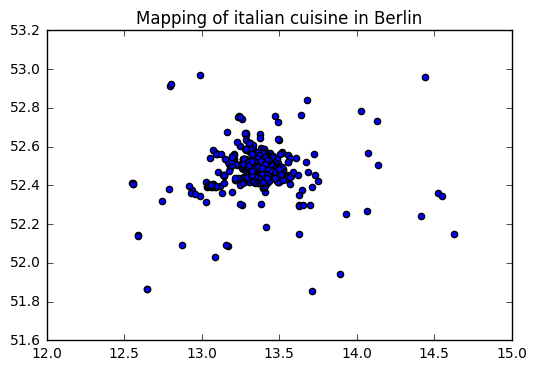

In [23]:
# from mpl_toolkits.basemap import Basemap  # Import not working, didn't find a way to plot berlin borders over it

plt.scatter([n[0] for n in italian_places], [n[1] for n in italian_places])
plt.title('Mapping of italian cuisine in Berlin')
plt.show()

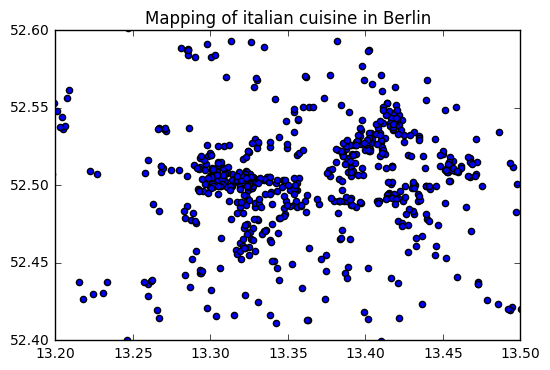

In [47]:
plt.scatter([n[0] for n in italian_places], [n[1] for n in italian_places])
plt.title('Mapping of italian cuisine in Berlin')
f = 1
plt.axis([13.2, 13.5 , 52.4, 52.6])  # Ration 3 / 1.6
plt.show()

## Ideas for Improvement

The data for Berlin is generally on a high level. Common standards are partly missing for values like maxspeed on ways. It should be possible to work on this in a programmatical way.

## Conclusion

Berlin is big and cleaning up all the \"fixme\" and other open ends is a lifetime job. The data is generally considering the size quite good.